# Chinese Character Recognition with Scikit-Learn Logistic Regression

_By Joshua Whittemore_

1. This is a 'proof of concept' notebook to show that logistic regression is one way to classify Chinese characters.
<br><br>
2. This might be a good starting point for beginners.  Other ways will certainly work better - in particular a convolutional neural network.
<br><br>
3. The dataset used in this notebook was collected by __Ryan Harper__ and presented by __Matt Borthwick__ at an informal meetup of the __[Portland Data Science Group](https://www.meetup.com/Portland-Data-Science-Group/)__  that Matt organized.
<br><br>
4. There is a good walkthrough of applying logistic regression to the classic MNIST dataset __[here](https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a)__.  It's a very similar task to recognizing Chinese characters.



# 1. Read in the Images into Memory

In [1]:
import os, sys, glob, random

print(f"Using Python version {sys.version}.")

random.seed(1)

Using Python version 3.6.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)].


In [2]:
from imageio import imread

INPUT_DIR = '/Users/work/Projects/chinese-chars/inputs/tcc_bmp'

# Build a dictionary where key is the Chinese character code, e.g. 
# 'a440' and value is a list of the images in grayscale format.

# Note that since the source images are bitmaps, the only values 
# in the image arrays will be 255 (white) and 0 (black).

codes_to_bitmaps = {}

for character_code in next(os.walk(INPUT_DIR))[1]:
    bitmap_filenames = glob.glob(f"{INPUT_DIR}/{character_code}/*.bmp")
    
    # print(f"Loading {len(bitmap_filenames)} images for character code '{character_code}'.'")

    # Using imread 'L' switch so will read in grayscale, not 3-channel rgb, see:
    # https://imageio.readthedocs.io/en/stable/format_bmp-pil.html#bmp-pil
    bitmaps = [
        imread(bitmap_filename, pilmode= "L") 
        for bitmap_filename in bitmap_filenames
    ]

    codes_to_bitmaps[character_code] = bitmaps


# 2. Basic Stats

In [3]:
import numpy as np

print(f"There are {len(codes_to_bitmaps)} different Chinese characters in the set.")

num_images = sum([len(images) for images in codes_to_bitmaps.values()])
print(f"There are a total of {num_images} images in the set.")

image_shape = next(iter(codes_to_bitmaps.values()))[0].shape
print(f"The shape of each image is {image_shape}, and each has {np.prod(image_shape)} pixels.")


There are 186 different Chinese characters in the set.
There are a total of 8391 images in the set.
The shape of each image is (65, 79), and each has 5135 pixels.


# 3. Histograms of Image Frequency By Character Code

In [4]:
# Convert dict to list of (char_code, image) tuples, sorted
# by the number of images.  Should have skipped the dict above
# and just done this to start.
sorted_codes_to_bitmaps = sorted(
    codes_to_bitmaps.items(), 
    key=lambda kv: len(kv[1])
)

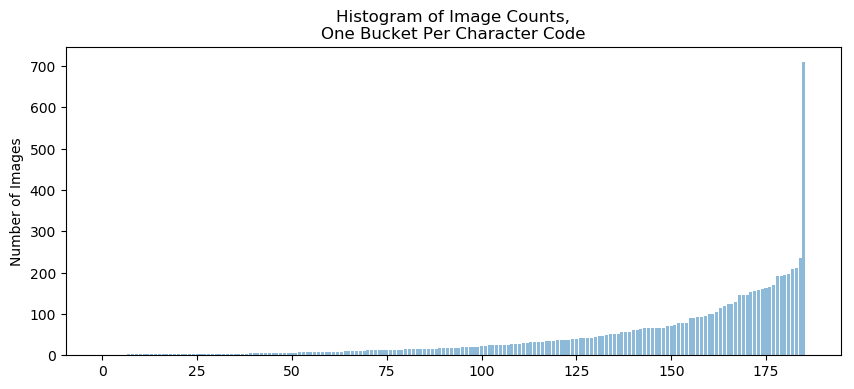

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcdefaults()

image_counts = [len(bitmaps) for (code, bitmaps) in sorted_codes_to_bitmaps]

y_pos = np.arange(len(sorted_codes_to_bitmaps))

plt.figure(figsize=(10,4))
plt.bar(y_pos, image_counts, align='center', alpha=0.5)
plt.ylabel('Number of Images')
plt.title("Histogram of Image Counts,\nOne Bucket Per Character Code")

 
plt.show()

In [6]:
# Take the Top 10 by count
top10_codes_to_bitmaps = sorted_codes_to_bitmaps[-10:]

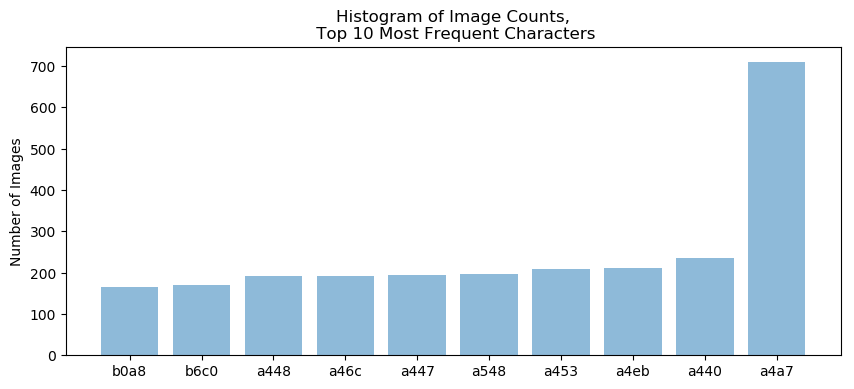

In [7]:
plt.rcdefaults()

image_counts = [len(bitmaps) for (code, bitmaps) in top10_codes_to_bitmaps]
codes = [code for (code, bitmaps) in top10_codes_to_bitmaps]
y_pos = np.arange(len(top10_codes_to_bitmaps))


plt.figure(figsize=(10,4))
plt.bar(y_pos, image_counts, align='center', alpha=0.5)
plt.xticks(y_pos, codes)
plt.ylabel('Number of Images')
plt.title("Histogram of Image Counts,\n Top 10 Most Frequent Characters")
 
plt.show()

# 4. Sample Images For Each Character

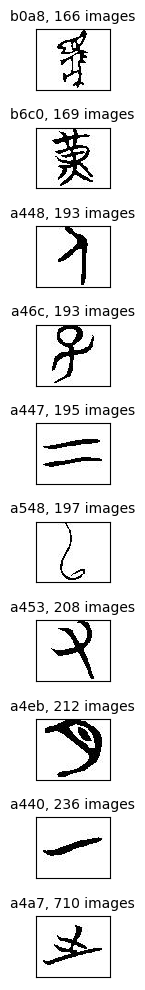

In [8]:
fig = plt.figure(figsize=(4, 10))

for (i, (code, bitmaps)) in enumerate(top10_codes_to_bitmaps):
    image_count = len(bitmaps)
    img = bitmaps[0]

    fig.add_subplot(10, 1, i+1)

    plt.tick_params(
        axis='both', 
        which='both', 
        bottom=False, 
        top=False, 
        labelbottom=False, 
        right=False, 
        left=False, 
        labelleft=False
    )   
    
    ax = fig.gca()
    ax.set_title(f"{code}, {image_count} images", fontsize=10)

    
    ax.set_title
    plt.imshow(img, cmap='gray')
    
  
fig.tight_layout()
plt.show()

# 5. Prepare Data for Logistic Regression

In [9]:
# Have n images, each image has m features/pixels.
# Want an n x m feature matrix, should be a numpy ndarray.

images = []
labels = []

for (code, image_set) in top10_codes_to_bitmaps:
    for image in image_set:
        labels.append(code)
        images.append(image)

        
print(f"There are a total of {len(labels)} examples in the set.")        

There are a total of 2479 examples in the set.


In [10]:
labels = np.array(labels)
images = np.array(images)

print(images.shape)

(2479, 65, 79)


In [11]:
images = images.reshape(len(labels), -1)
print(f"Shape of feature matrix is now n images by m features/pixels: {images.shape}")


Shape of feature matrix is now n images by m features/pixels: (2479, 5135)


In [12]:
# Split data into training and test sets.  Use stratify option
# so unbalanced classes will be proportionately divided between 
# train and test sets.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, 
                                                    labels, 
                                                    test_size=0.20,
                                                    stratify=labels,
                                                    random_state=0
                                                   )

# 6. Establish a Baseline Accuracy


* To establish a baseline accuracy, predict the most commonly occuring character for all examples.
* That is a4a7, which occurs 710 times out of 2479 examples in the top 10 set.
* Hopefully, logistic regression will do better than this.

In [13]:
from sklearn.metrics import accuracy_score

y_pred = np.repeat('a4a7', len(y_test))

score = accuracy_score(y_test, y_pred)

print(f"A baseline score for this classification task is {(score * 100):.1f}%.")

A baseline score for this classification task is 28.6%.


# 7. Train Logistic Regression Model

In [14]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()

In [15]:
%time lr_model.fit(X_train, y_train)

CPU times: user 41.6 s, sys: 638 ms, total: 42.3 s
Wall time: 21.6 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# 8. Evaluate Model

In [16]:
# Predict first 5 members of test set.

print("Actual Predicted:")
for i in range(5):
    y_pred = lr_model.predict(X_test[i].reshape(1,-1))[0]
    print(f" {y_test[i]}  {y_pred}")


Actual Predicted:
 a453  a4eb
 a4a7  a4a7
 a448  a448
 a4eb  a4eb
 a440  a440


In [17]:
# What was train accuracy?

y_pred = lr_model.predict(X_train)

print(f"Train accuracy score was {accuracy_score(y_pred, y_train)*100.:.1f}%")



Train accuracy score was 100.0%


In [18]:
# What was the test accuracy?

y_pred = lr_model.predict(X_test)

print(f"Test accuracy score was {accuracy_score(y_pred, y_test)*100.:.1f}%")


Test accuracy score was 93.8%


# 9. Conclusions

1. Logistic regression is a good starting approach for classifiying Chinese characters.  While the baseline prediction method correctly classified characters 28.6% of the time, logistic regression had a test accuracy of 93.8%.
<br><br>
2. Provides reasonable results if each class has a lot of examples.  The minimum in this study was 166.
<br><br>
3. A training accuracy of 100% and a test accuracy of 93% suggests __strongly__ that the model is overfitting the data.  Adding regularization by setting the C parameter to smaller values didn't seem to do any good.
